# Comparison of dependency relations in evaluation

In this notebook, we will look closer at how different classes of dependency relations affect the evaluation results for each language. We will mainly be interested in the absolute precision and recall for each label class, and comparing their score to the overall labeled attachment score in each language.

We will be using the parsing results from [Tiedemann (2014)](http://aclweb.org/anthology/W/W15/W15-2137.pdf), where 10 languages from UD 1.0 where trained with Mate tools. 

Mate uses all available morphological features, if there are any available. Therefore, German, French, and Spanish might be affected negatively since they lack morphological features in the training data. At least for UD 1.1. I couldn't find this data for version 1.0, so there might be even more languages lacking feature data.

The classes to be analyzed are:

#### Functional and content dependents
As specified in [A manual classification of dependency relations](/notebooks/A%20manual%20classification%20of%20dependency%20relations.ipynb)

- Functional dependents
- Content dependendents

#### Dependent classes as specified in the [UD documentation](http://universaldependencies.github.io/docs/u/dep/index.html)

- Classes expected to perform better than overall LAS for __synthetic__ languages:
  - __Core dependents of clausal predicates__: nsubj, csubj, nsubjpass, csubjpass, dobj, ccomp, xcomp, iobj
  - __Non-core dependents of clausal predicates__: nmod, advcl, advmod, neg
  - __Noun dependents, excluding _det_ and _neg___: nummod, acl, amod, appos, nmod
  - __Coordination, excluding _cc_ and _punct___: conj
  - 
- Classes expected to perform better than overall LAS for __isolated__ languages:
  - __Special clausal dependents__: vocative, aux, mark, discourse, auxpass, punct, expl, cop
  - __Case-marking, prepositions, possessive__: case


## Things to keep in mind when looking at the results

- Irish and Hungarian has fairly little data, and can't probably be trusted. 
- Czech has A LOT of data.

In [6]:
# My classes
content_dependents = ("acl", "advcl", "advmod", "amod", "appos", "ccomp", "compound", "conj", "csubj", "csubjpass", "dislocated", "dobj", "iobj", "list", "name", "nmod", "nsubj", "nsubjpass", "nummod", "parataxis", "remnant", "root", "vocative", "xcomp")
function_dependents = ('aux', 'auxpass', 'case', 'cc', 'cop', 'det', 'expl', 'mark', 'neg', 'mwe')
nonsemantic_dependents = ("punct", "discourse", "reparandum", "dep", "goeswith", "foreign")

# UD classes
core_dependents = ['nsubj', 'csubj', 'nsubjpass', 'csubjpass', 'dobj', 'ccomp', 'xcomp', 'iobj']
noncore_dependents = ['nmod', 'advcl', 'advmod', 'neg']
noun_dependents = ['nummod', 'acl', 'amod', 'appos', 'nmod']
coordination_dependents = ['conj']
special_clausal_dependents = ['vocative', 'aux', 'mark', 'discourse', 'auxpass', 'expl', 'cop']
other_functional_dependents = ['det', 'cc', 'case', 'mwe']

all_labels = content_dependents + function_dependents + nonsemantic_dependents

In [7]:
%matplotlib inline
import matplotlib
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.style.use('ggplot')

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys, os
sys.path.append("../tools/")
import udeval

import pandas as pd
import seaborn as sns
from collections import defaultdict

output_path = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/baseline-UD/"

system_output = {"en": "en-en.all.conll.conllu",
                 "cs": "cs-cs.all.conll.conllu",
                 "de": "de-de.all.conll.conllu",
                 "en": "en-en.all.conll.conllu",
                 "es": "es-es.all.conll.conllu",
                 "fi": "fi-fi.all.conll.conllu",
                 "fr": "fr-fr.all.conll.conllu",
                 "ga": "ga-ga.all.conll.conllu",
                 "hu": "hu-hu.all.conll.conllu",
                 "it": "it-it.all.conll.conllu",
                 "sv": "sv-sv.all.conll.conllu"}

gold_file = {"en": "en-ud-test.conllu",
             "cs": "cs-ud-test.conllu",
             "de": "de-ud-test.conllu",
             "en": "en-ud-test.conllu",
             "es": "es-ud-test.conllu",
             "fi": "fi-ud-test.conllu",
             "fr": "fr-ud-test.conllu",
             "ga": "ga-ud-test.conllu",
             "hu": "hu-ud-test.conllu",
             "it": "it-ud-test.conllu",
             "sv": "sv-ud-test.conllu"}

In [1]:
def labeled_attachment_scores():
    las = {}
    for lang in system_output.keys():
        score = udeval.attachment_score(output_path + system_output[lang], output_path + gold_file[lang], labeled=True)
        las[lang] = score
    return pd.Series(las)
        
def precision_recall_filter_labels(labels):
    prec_recs = {"precision": [], "recall": []}
    index = []
    for lang in system_output.keys():
        precision, recall = udeval.labels_precision_recall(output_path + system_output[lang], 
                                                           output_path + gold_file[lang], 
                                                           labels=labels)
        index.append(lang)
        prec_recs["precision"].append(precision)
        prec_recs["recall"].append(recall)

    return pd.DataFrame(prec_recs, index=index).sort_values("precision")

##  Overall language LAS

To be used when looking at relative performance.

In [2]:
all_labels_results = precision_recall_filter_labels(all_labels)
all_labels_results

NameError: name 'all_labels' is not defined

## Performance for label-language pairs

Can we see any general trends by looking at the performance of each individual label across languages?

### Performance relative to language LAS

In [10]:
label_result = dict()
for label in all_labels:
    label_result[label] = precision_recall_filter_labels([label])

### Absolute label-language performance (useless)

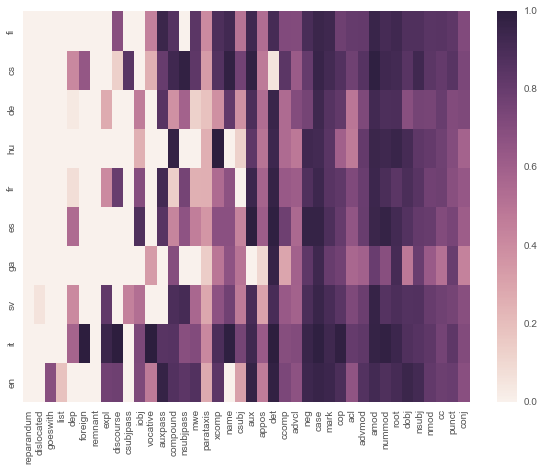

In [11]:
# Sort precision heatmap with languages according to standard ttr, 
# dependency labels according to cross-language entropy
dep_entropy = pd.Series.from_csv('../data/crosslingual_dependency_entropy.csv').index
dep_entropy = [label for label in dep_entropy if label != "subj"]  # remove hebrew bug
sttr = ["fi", "cs", "de", "hu", "fr", "es", "ga", "sv", "it", "en"]
labels_precision = pd.DataFrame({y:x['precision'] for y,x in label_result.items()})
absolute_precision_scores = labels_precision.ix[sttr][dep_entropy].fillna(0)
sns.heatmap(absolute_precision_scores);

I don't think this one gave us that much insight. Let's look at relative performance instead.

### Relative label-language performance

Subtract the languages' LAS score from each score

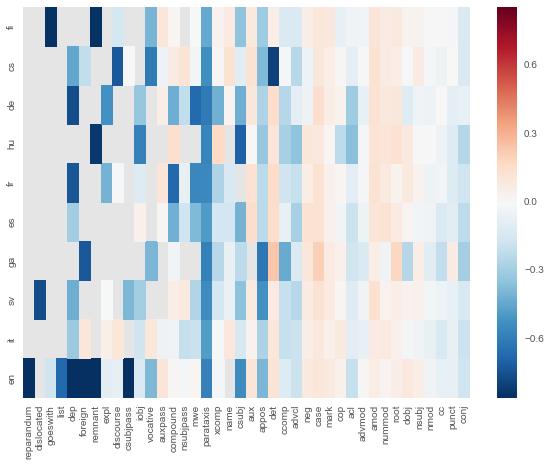

In [12]:
relative_precision_scores = labels_precision.subtract(all_labels_results['precision'], axis=0).ix[sttr][dep_entropy]
sns.heatmap(relative_precision_scores);

It's hard to read any general trends into it. That we have negative results to the left should just mean that rarely used relations are harder to predict. Not too surprising. The more evenly spread out a dependency is between the languages, the more does its result reflect the overall result of the model for that language. punct, cc, nmod are examples of relations that have similar scores as its model (a lot of white).

Irish has several classes that strongly bump up the performance more than other classes: det, case, root. 

# Performance for dependency classes

We calculate the precision and recall only using the labels classified as content relations. We then subtract the LAS to present how large of an increase (or reduction) in results the label class gets.

### Content and function relations

#### Absolute performance

In [13]:
content_dependents_result = precision_recall_filter_labels(content_dependents)
function_dependents_result = precision_recall_filter_labels(function_dependents)
results_dict = {"Content dependents": content_dependents_result, 
                "Function dependents": function_dependents_result}

content_function_results = pd.concat(results_dict.values(), keys=results_dict.keys(), axis=1)
content_function_results

Function dependents           Content dependents          
             precision    recall          precision    recall
cs            0.833230  0.922424           0.874407  0.846257
de            0.910889  0.890418           0.744235  0.755051
en            0.937604  0.932539           0.832778  0.833458
es            0.929606  0.932036           0.787835  0.786304
fi            0.882876  0.893473           0.840810  0.838720
fr            0.883630  0.893808           0.781991  0.772156
ga            0.866348  0.857480           0.634270  0.639276
hu            0.890435  0.893543           0.825070  0.824610
it            0.966487  0.967197           0.854021  0.854021
sv            0.880820  0.892445           0.809207  0.803792

#### Relative performance

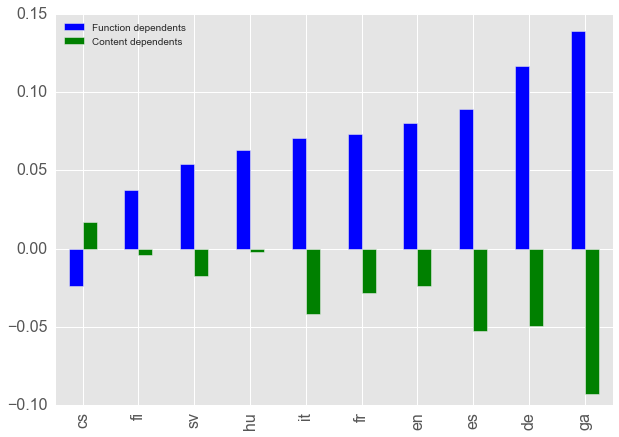

In [14]:
content_function_precisions = content_function_results.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
content_function_precisions.sort_values('Function dependents').plot(kind='bar', fontsize=16)

## Conclusion

It is easier for all languages to parse function dependencies than it is to parse content dependencies, with the exception of Czech. For Irish and German, the results are noticably higher. English is not as far to the right as we would have liked, but we are at least seeing some sort of trend where roman and german languages are to the right, with finnish and hungarian to the left (sorted by relative function dependent performance). 

# UD classes

### Absolute performance

In [16]:
core_dependent_result = precision_recall_filter_labels(core_dependents)
noncore_dependents_result = precision_recall_filter_labels(noncore_dependents)
noun_dependents_result = precision_recall_filter_labels(noun_dependents)
coordination_dependents_result = precision_recall_filter_labels(coordination_dependents)
special_clausal_dependents_result = precision_recall_filter_labels(special_clausal_dependents)
other_functional_dependents_result = precision_recall_filter_labels(other_functional_dependents)

ud_result_dict = {'Core': core_dependent_result,
                  'Noncore': noncore_dependents_result,
                  'Noun': noun_dependents_result,
                  'Coordination': coordination_dependents_result,
                  'Special clausal': special_clausal_dependents_result,
                  'Functionals': other_functional_dependents_result}

ud_class_result = pd.concat(ud_result_dict.values(), keys=ud_result_dict.keys(), axis=1)
ud_class_result

Noncore           Special clausal                Noun            \
   precision    recall       precision    recall precision    recall   
cs  0.839922  0.833903        0.894725  0.929806  0.886996  0.828843   
de  0.735621  0.724027        0.859873  0.816768  0.777325  0.768714   
en  0.825188  0.820203        0.926512  0.928397  0.822080  0.805363   
es  0.791529  0.787879        0.895093  0.887584  0.815065  0.798473   
fi  0.831358  0.830722        0.869027  0.897623  0.856928  0.848620   
fr  0.774648  0.739910        0.830357  0.845455  0.800134  0.760966   
ga  0.628655  0.596394        0.791339  0.700348  0.635526  0.609079   
hu  0.803709  0.797546        0.800000  0.846154  0.848371  0.819613   
it  0.830829  0.844335        0.931464  0.934375  0.863364  0.867175   
sv  0.779885  0.779324        0.888585  0.888585  0.824331  0.813845   

   Functionals                Core           Coordination            
     precision    recall precision    recall    precision    recall  
cs    0.811670  0.919803  0.883905  0.889394     0.736480  0.735467  
de    0.930018  0.915477  0.686353  0.728741     0.724858  0.623165  
en    0.937256  0.929587  0.901451  0.893263     0.685484  0.676136  
es    0.935740  0.940493  0.820513  0.829511     0.615152  0.611446  
fi    0.882845  0.882845  0.864776  0.845806     0.718336  0.752475  
fr    0.894201  0.904613  0.833713  0.834664     0.642241  0.634043  
ga    0.884929  0.899586  0.605740  0.657377     0.439024  0.533333  
hu    0.898167  0.896341  0.825959  0.828402     0.582609  0.582609  
it    0.973389  0.973676  0.840956  0.828045     0.709150  0.720930  
sv    0.877144  0.892647  0.834365  0.822487     0.691160  0.665193

## Relative performance

__Don't make the same thought error as I did for several hours and couldn't wrap my head around__: Despite e.g. "case" not being especially common, it will still show large percentages in these graphs, since we are only measuring the performance of all case instances. This is why the case and coordination performance difference below will be much higher than the others, since these classes only have one dependent and thus aren't evened out by other dependents.

It is therefore not that weird that case and coordination performance doesn't alter between languages.

### Per language

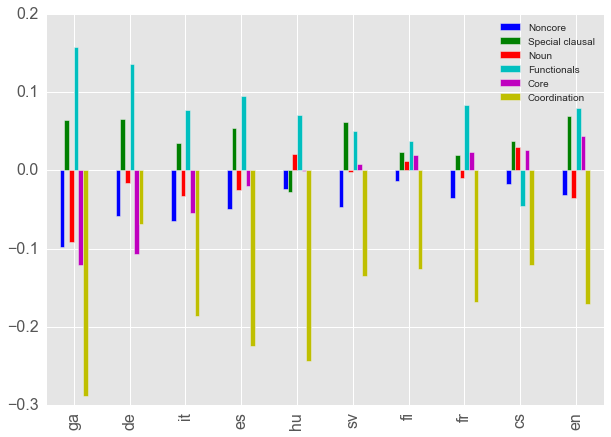

In [17]:
relative_ud_class_result = ud_class_result.subtract(all_labels_results, level=1).xs('precision', level=1, axis=1)
relative_ud_class_result.sort_values('Core').plot(kind='bar', fontsize=16)

### Per class

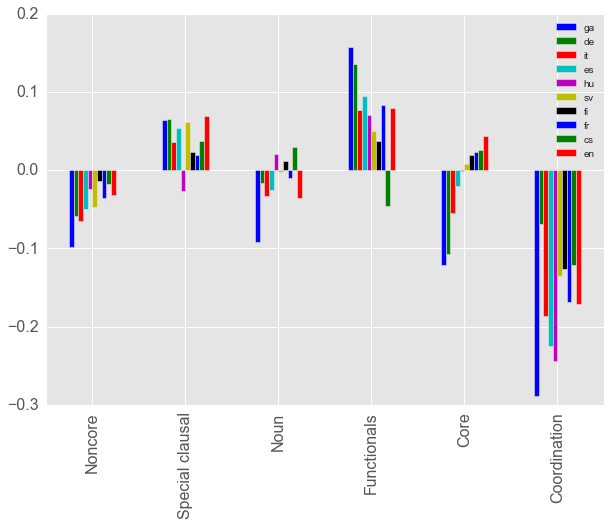

In [18]:
relative_ud_class_result.sort_values("Core").transpose().plot(kind='bar', fontsize=16)

__Weird__: Only looking at core dependents for English increases the performance. I would expect it to worsen.

## Cumulative results

What happens if we add dependency classes cumulatively (i think that's a word)?

If we add the classes in a sort of content -> function order, we would expect English to get lower and lower results, while Finnish would rise. Right now I just kind of chose the class order from gut feeling.

In [19]:
add_order = [('core', core_dependents), 
             ('noun', noun_dependents), 
             ('non_core', noncore_dependents), 
             ('coord', coordination_dependents), 
             ('specl', special_clausal_dependents),
             ('functionals', other_functional_dependents)]


labels = []
cumul_results = []
cumul_name = ""
for class_name, label_class in add_order:
    labels += label_class
    labels_result = precision_recall_filter_labels(labels)
    cumul_name += "+" + class_name
    cumul_results.append((cumul_name, labels_result))

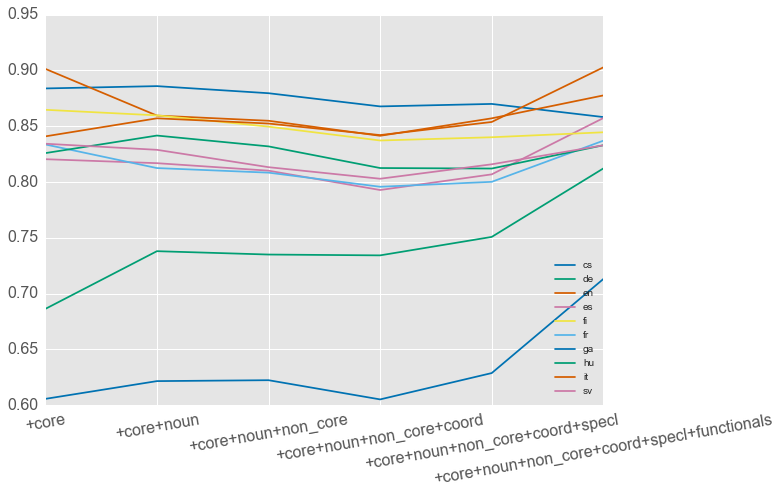

In [20]:
cmap1 = mpl.colors.ListedColormap(sns.color_palette("colorblind", 10))
pd.DataFrame([x[1]['precision'] for x in cumul_results], index=[x[0] for x in cumul_results]).plot(rot=10, fontsize=16, cmap=cmap1)

## Total change from +core to +core+noun+non_core+coord+specl+functionals

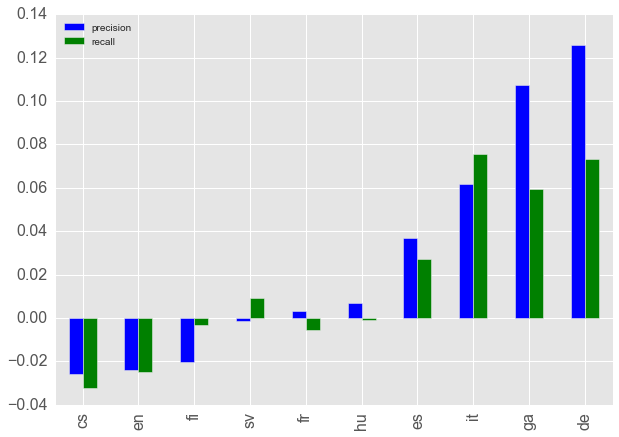

In [21]:
(cumul_results[-1][1] - cumul_results[0][1]).sort_values("precision").plot(kind='bar', fontsize=16)

## Conclusion

I'm not too happy with the results. Adding more and more "functional" dependent classes should mean that English gains more and more. Instead it is the language whose performance turns worst. The results for italian and german are more like what I'm expecting. I have to sleep on this.